In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import random
random_seed = 42
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")
# Step 2: Train a Model
X = data.drop("quality", axis=1)
y = data["quality"]
# y = data['quality'].apply(lambda x: 1 if x >= 7 else 0)  # 2 class: >=7 high quality <7 low quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=random_seed)



In [8]:
X_train[0]

KeyError: 0

In [10]:
instance = X_train.iloc[3]

In [11]:
instance

fixed acidity            8.80000
volatile acidity         0.68500
citric acid              0.26000
residual sugar           1.60000
chlorides                0.08800
free sulfur dioxide     16.00000
total sulfur dioxide    23.00000
density                  0.99694
pH                       3.32000
sulphates                0.47000
alcohol                  9.40000
Name: 834, dtype: float64

In [ ]:
3 - 834
205 - 898


In [13]:
len(X_train)

1279

In [17]:
distance_series

493      58.480005
354     144.145307
342      13.628419
834       0.000000
705      31.714117
           ...    
1130     17.067328
1294     38.117780
860      62.039190
1459     12.336457
1126     18.407348
Length: 1279, dtype: float64

In [3]:
instance = X_train.iloc[17]
from sklearn.metrics.pairwise import euclidean_distances
# Calculate the Euclidean distance from the instance to all other instances in the dataset
# Calculate the Euclidean distance from the instance to all other instances in the dataset
distances = euclidean_distances(X_train.drop('volatile acidity', axis=1), [instance.drop('volatile acidity')])
print(len(distances))
# Convert distances to a Series
# Convert distances to a Series using a default numeric index
distance_series = pd.Series(distances.flatten())

# Print the length of the distance series
print("Length of distance series:", len(distance_series))


similarity_threshold = distance_series.quantile(0.005)

# Filter for instances that are similar
# Use the numeric index to access the rows in X_train corresponding to the similar instances
similar_instances = X_train.iloc[distance_series[distance_series <= similarity_threshold].index]


# Sort these similar instances by volatile acidity, ascending order (lowest first)
similar_sorted_by_acidity = similar_instances.sort_values('volatile acidity', ascending=False)

# Get the index of the instance with the lowest volatile acidity
most_similar_low_acidity_index = similar_sorted_by_acidity.index[0]

position = X_train.index.get_loc(most_similar_low_acidity_index)

# Print the index of the most similar instance with the lowest volatile acidity
print("The index of the most similar instance with the lowest volatile acidity is:", position)

1279
Length of distance series: 1279
The index of the most similar instance with the lowest volatile acidity is: 650


In [22]:
position = X_train.index.get_loc(1555)

In [23]:
position

830

In [3]:
import numpy as np
target_feature = 'volatile acidity'
target_feature_2 = 'Alcohol'
features = X_train.drop([target_feature,'pH','fixed acidity', 'chlorides','density','residual sugar'], axis=1)

# Calculate pairwise Euclidean distances between all instances
distances = euclidean_distances(features, features)
# Create a DataFrame from the distance matrix, setting infinite distance for diagonal (self-pair)
distance_df = pd.DataFrame(distances, index=X_train.index, columns=X_train.index)
np.fill_diagonal(distance_df.values, np.inf)

# Calculate the absolute differences in the target feature for all pairs
target_diffs = abs(X_train[target_feature].values[:, None] - X_train[target_feature].values)

# Create a DataFrame from the target differences
target_diff_df = pd.DataFrame(target_diffs, index=X_train.index, columns=X_train.index)

# Find the pair with the minimum distance and maximum target feature difference
# Use a combined metric or prioritize one over the other
score_df = distance_df + (1 - (target_diff_df / target_diff_df.max().max()))

# Find the index of the minimum score
min_score_idx = score_df.stack().idxmin()
most_similar, most_different = min_score_idx

print(f"Most similar pair with highest difference in {target_feature}: Index {X_train.index.get_loc(most_similar)} and Index {X_train.index.get_loc(most_different)}")
print(f"Difference in {target_feature}: {target_diff_df.loc[most_similar, most_different]}")
print(f"Distance between instances: {distance_df.loc[most_similar, most_different]}")



NameError: name 'euclidean_distances' is not defined

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances

target_feature_1 = 'volatile acidity'
target_feature_2 = 'citric acid'
target_feature_3 = 'alcohol'

weight_1 = 10  # Weight for volatile acidity
weight_2 = 1 # Weight for Alcohol to normalize the scale difference
weight_3 = 1

features = X_train.drop([target_feature_1, target_feature_2,target_feature_3, 'pH', 'fixed acidity', 'chlorides', 'density', 'residual sugar'], axis=1)

# Calculate pairwise Euclidean distances between all instances
distances = euclidean_distances(features, features)

# Create a DataFrame from the distance matrix, setting infinite distance for diagonal (self-pair)
distance_df = pd.DataFrame(distances, index=X_train.index, columns=X_train.index)
np.fill_diagonal(distance_df.values, np.inf)

# Calculate the differences in the target features for all pairs
target_diffs_1 = -(X_train[target_feature_1].values[:, None] - X_train[target_feature_1].values)
target_diffs_2 = X_train[target_feature_2].values[:, None] - X_train[target_feature_2].values
target_diffs_3 = -(X_train[target_feature_3].values[:, None] - X_train[target_feature_3].values)

# Normalize the differences
target_diffs_1_norm = target_diffs_1 / (X_train[target_feature_1].max() - X_train[target_feature_1].min())
target_diffs_2_norm = target_diffs_2 / (X_train[target_feature_2].max() - X_train[target_feature_2].min())
target_diffs_3_norm = target_diffs_3 / (X_train[target_feature_3].max() - X_train[target_feature_3].min())
# Apply weights to the normalized differences
weighted_diff_1 = weight_1 * target_diffs_1_norm
weighted_diff_2 = weight_2 * target_diffs_2_norm
weighted_diff_3 = weight_3 * target_diffs_3_norm

# Create DataFrames from the weighted differences
target_diff_df_1 = pd.DataFrame(weighted_diff_1, index=X_train.index, columns=X_train.index)
target_diff_df_2 = pd.DataFrame(weighted_diff_2, index=X_train.index, columns=X_train.index)
target_diff_df_3 = pd.DataFrame(weighted_diff_3, index=X_train.index, columns=X_train.index)
# Filter for pairs where one instance has both target features higher than the other instance
condition = (target_diff_df_1 > 0) & (target_diff_df_2 > 0) & (target_diff_df_3 > 0)

# Combine the weighted differences into a single metric for the filtered pairs
combined_target_diff_df = target_diff_df_1[condition] + target_diff_df_2[condition] + target_diff_df_3[condition]

# Use a combined metric: prioritize distance and the specified weighted differences
score_df = distance_df + (1 - (combined_target_diff_df / combined_target_diff_df.max().max()))

# Find the index of the minimum score
min_score_idx = score_df.stack().idxmin()
most_similar, most_different = min_score_idx

print(f"Most similar pair with one having higher {target_feature_1} and {target_feature_2}: Index {X_train.index.get_loc(most_similar)} and Index {X_train.index.get_loc(most_different)}")
print(f"Difference in {target_feature_1}: {target_diff_df_1.loc[most_similar, most_different]}")
print(f"Difference in {target_feature_2}: {target_diff_df_2.loc[most_similar, most_different]}")
print(f"Distance between instances: {distance_df.loc[most_similar, most_different]}")


Most similar pair with one having higher volatile acidity and citric acid: Index 361 and Index 800
Difference in volatile acidity: 4.691780821917809
Difference in citric acid: 0.49
Distance between instances: 0.10000000000009664


In [7]:
X_train['fixed acidity'].min()

4.6

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import numpy as np
import re
from matplotlib.collections import LineCollection
import random
random_seed = 42
import matplotlib.pyplot as plt
np.random.seed(random_seed)
random.seed(random_seed)

def get_model():
    np.random.seed(random_seed)
    random.seed(random_seed)
    # Step 1: Load the Dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = pd.read_csv(url, delimiter=";")

    # Step 2: Train a Model
    X = data.drop("quality", axis=1)
    y = data["quality"]
    # y = data['quality'].apply(lambda x: 1 if x >= 7 else 0)  # 2 class: >=7 high quality <7 low quality
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=random_seed)
    model.fit(X_train, y_train)
    y_test = np.array(y_test)
    pred = model.predict(X_train)
    y_train= np.array(y_train)
    
    k = 0
    n=0
    for i in range(len(pred)):
        if abs(pred[i] - y_train[i])<0.2:
            k+=1
            if y_train[i]==1:
                # print(i)
                n+=1
    print('acc:',k/len(pred))
    print('high quality:',n/len(pred))
    return model, X_train, y_train,X,y

In [10]:
len(X_train)

1279

In [6]:


model, X_train, y_train,X,y = get_model()

acc: 0.7075840500390931
high quality: 0.0


In [19]:
X_train['citric acid']

493     0.31
354     0.40
342     0.47
834     0.26
705     0.15
        ... 
1130    0.00
1294    0.10
860     0.06
1459    0.35
1126    0.26
Name: citric acid, Length: 1279, dtype: float64

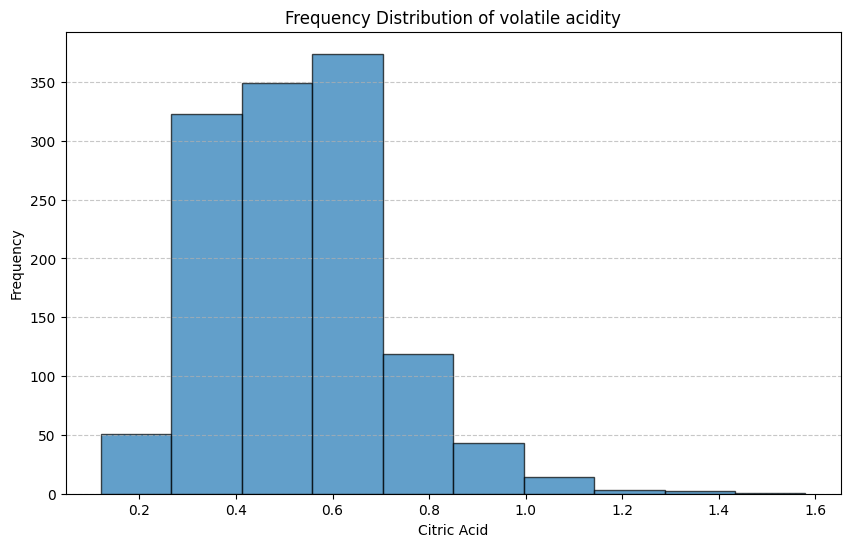

In [8]:
# Plot frequency histogram for 'citric acid'
name='volatile acidity'
plt.figure(figsize=(10, 6))
plt.hist(X_train[name], bins=10, edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution of ' + name)
plt.xlabel('Citric Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [2]:
# Step 4: Apply GAM
# Step 4: Apply GAM
np.random.seed(random_seed)
random.seed(random_seed)
prediction = model.predict(X_train)
# gam = LinearGAM( s(1) + s(2) + s(5) + s(6) + s(9) + s(10)).fit(X_train, prediction)

gam = LinearGAM(
    s(1, lam=0.1) +  # Adjust lambda for term 1
    s(2, lam=1) +  # Adjust lambda for term 2
    s(5, lam=20) +  # Adjust lambda for term 5
    s(6, lam=10) +  # Adjust lambda for term 6
    s(9, lam=10) +  # Adjust lambda for term 9
    s(10, lam=1)   # Adjust lambda for term 10
).fit(X_train, prediction)
xxs = []
# Dictionary to store the magnitude of change and shape information
feature_analysis = {}
# Plot GAM
plt.figure(figsize=(15, 10))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(2, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    xxs.append(XX)
    plt.plot(XX[:, term.feature], pdep, linewidth=2, label='Partial Dependence')
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='grey', alpha=0.2, label='95% Confidence Interval')
    plt.title(data.columns[term.feature], fontsize=18)
    plt.legend()
    
    # Calculate magnitude of change
    magnitude_of_change = np.ptp(pdep)  # Peak to peak (max - min)

    # Shape of the plot (identify patterns)
    slopes = np.diff(pdep)
    steep_slopes = np.any(np.abs(slopes) > np.mean(np.abs(slopes)) * 2)  # Identify if there are any steep slopes
    peaks_troughs = len(np.where(np.diff(np.sign(slopes)))[0])  # Number of peaks and troughs

    # Store information in the dictionary
    feature_analysis[data.columns[term.feature]] = {
        'magnitude_of_change': magnitude_of_change,
        'steep_slopes': steep_slopes,
        'peaks_troughs': peaks_troughs
    }
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

In [25]:
predicted_qualities = gam.predict(X_train)

# Calculate the average of these predictions
average_predicted_quality = np.mean(predicted_qualities)

print("Average Predicted Quality (Baseline Quality):", average_predicted_quality)

Average Predicted Quality (Baseline Quality): 5.62770914772002


In [22]:
import numpy as np
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Example data (assumed to be already defined)
# X_train, y_train, and model as before

# Plot PDPs for top features
top_features = ['citric acid', 'alcohol', 'volatile acidity']
plot_partial_dependence(model, X_train, top_features, grid_resolution=50)

plt.suptitle('Partial Dependence Plots for Top Features')
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/inspection/__init__.py)

In [23]:
# Predict the quality for all instances in X_train
predicted_qualities = gam.predict(X_train)

# Calculate the average of these predictions
average_predicted_quality = np.mean(predicted_qualities)

print("Average Predicted Quality for X_train:", average_predicted_quality)

Average Predicted Quality for X_train: 5.62770914772002


NameError: name 'plot_partial_dependence' is not defined

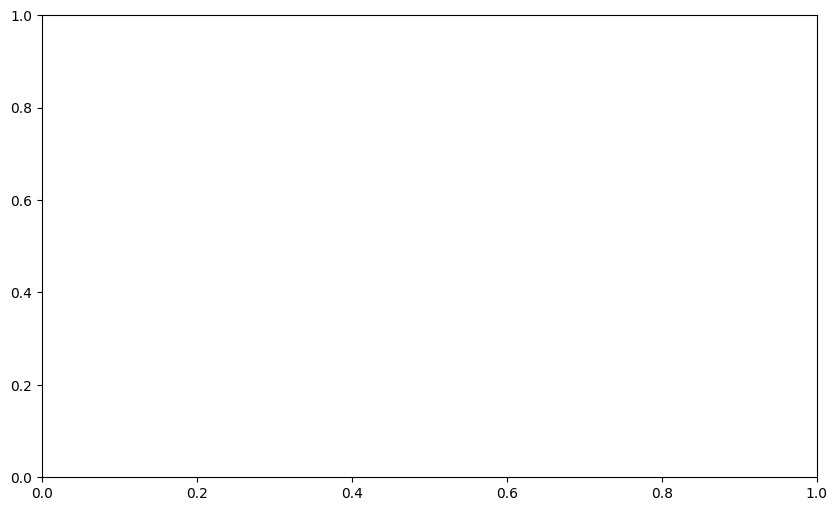

In [21]:
from sklearn.inspection import partial_dependence

features = [('alcohol', 'citric acid')]
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(model, X_train, features, grid_resolution=50, ax=ax)
plt.suptitle('2D Partial Dependence Plot for Alcohol and Citric Acid')
plt.show()

In [17]:
feature_analysis

{'volatile acidity': {'magnitude_of_change': 2.072465201390172,
  'steep_slopes': True,
  'peaks_troughs': 8},
 'citric acid': {'magnitude_of_change': 1.4517300298056222,
  'steep_slopes': True,
  'peaks_troughs': 9},
 'free sulfur dioxide': {'magnitude_of_change': 0.3259531050657221,
  'steep_slopes': True,
  'peaks_troughs': 2},
 'total sulfur dioxide': {'magnitude_of_change': 0.4745357090706286,
  'steep_slopes': True,
  'peaks_troughs': 4},
 'sulphates': {'magnitude_of_change': 0.8165317422301714,
  'steep_slopes': True,
  'peaks_troughs': 2},
 'alcohol': {'magnitude_of_change': 1.673693442575669,
  'steep_slopes': True,
  'peaks_troughs': 7}}

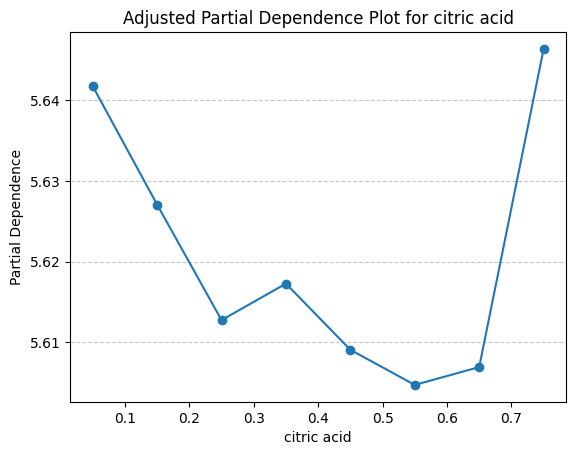

In [7]:
# Define threshold for low-frequency bins
threshold = 0

# Get histogram data
hist, bin_edges = np.histogram(X_train['citric acid'], bins=10)

# Identify low-frequency bins
low_freq_bins_indices = np.where(hist < threshold)[0]

# Combine low-frequency bins with adjacent bins
new_bins = []
for idx in range(len(bin_edges) - 1):
    if idx in low_freq_bins_indices:
        # Combine with next bin if it's not the last one, else with the previous one
        if idx < len(bin_edges) - 2:
            new_bins.append((bin_edges[idx], bin_edges[idx + 2]))
        else:
            new_bins.append((bin_edges[idx - 1], bin_edges[idx + 1]))
    else:
        new_bins.append((bin_edges[idx], bin_edges[idx + 1]))

# Remove duplicate bin ranges
new_bins = list(set(new_bins))
new_bins.sort()

# Custom function to plot PDP with adjusted bins
def custom_plot_pdp(model, X, feature, bins):
    pdp_values = []
    bin_centers = []
    for bin_start, bin_end in bins:
        mask = (X[feature] >= bin_start) & (X[feature] < bin_end)
        if mask.sum() > 0:
            bin_center = (bin_start + bin_end) / 2
            bin_centers.append(bin_center)
            X_temp = X.copy()
            X_temp[feature] = bin_center
            pdp_value = model.predict(X_temp).mean()
            pdp_values.append(pdp_value)
    plt.plot(bin_centers, pdp_values, marker='o')
    plt.title(f'Adjusted Partial Dependence Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot adjusted PDP for 'citric acid'
custom_plot_pdp(model, X_train, 'citric acid', new_bins)

In [17]:
feature_names = [
    'Crime Rate', '%Residential in Area', '% Business in Area',
    '','Air Pollution', '# Rooms in House', '%Pre-1940 Units',
    'Dist. to Business District', 'Highway Accessibility', 'Property Tax Rate', 'Student-Teacher Ratio',
    'B', '%\Lower Income in Area'
]

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_2067638/4023723943.py:5: SyntaxWarning: invalid escape sequence '\L'
  'B', '%\Lower Income in Area'


In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(25,10))
a = plot_tree(model, 
              feature_names=feature_names, 
              class_names=y, 
              filled=True, 
              rounded=True, 
              fontsize=14,
              max_depth=3)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestRegressor(random_state=42) instead.

<Figure size 2500x1000 with 0 Axes>

10


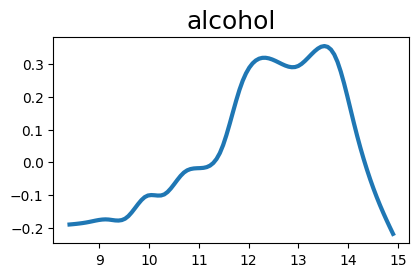

In [22]:
# Step 4: Apply GAM
# Step 4: Apply GAM

prediction = model.predict(X_train)
gam = LinearGAM( s(10)).fit(X_train, prediction)

xxs = []
# Plot GAM
plt.figure(figsize=(8, 10))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 2, i+1)
    XX = gam.generate_X_grid(term=i)
    xxs.append(XX)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX),linewidth=3)
    print(term.feature)
    plt.title(data.columns[term.feature],fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
# 选择一个实例进行解释
instance_idx = 0
instance = X_train.iloc[instance_idx]

# 使用GAM模型进行预测
predicted_value = gam.predict(instance.values.reshape(1, -1))[0]

# 指定要展示的特征
selected_features = [ 'volatile acidity', 'citric acid','free sulfur dioxide','total sulfur dioxide','sulphates', 'alcohol']
selected_feature_indices = [X.columns.get_loc(feature) for feature in selected_features]

# 计算每个特征的贡献
contributions = np.array([gam.partial_dependence(term=i, X=instance.values.reshape(1, -1)) for i in selected_feature_indices])

ValueError: cannot create grid for intercept term

In [10]:
selected_feature_indices

[1, 2, 5, 6, 9, 10]

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# gam = LinearGAM( s(1) + s(2)  + s(6) + s(9) + s(10)).fit(X_train, y_train)
# Train a GAM model
prediction = model.predict(X_train)

gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)).fit(X_train, prediction)

def plot_gam_contributions(gam, instance, contributions,selected_features, selected_feature_indices):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
    axes = axes.flatten()
    
    for idx, (feature, feature_idx) in enumerate(zip(selected_features, selected_feature_indices)):
        i=feature_idx
        ax = axes[idx]
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.9)
        
        
   
        ax.plot(XX[:, i], pdep)
        ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.1)
        
        # Highlight the instance's specific value on the shape function
        # 高亮实例的特定值在形状函数图上的位置
       
        
        ax.set_title(f'{feature}',fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Plot the contributions
plot_gam_contributions(gam, instance, contributions,selected_features, selected_feature_indices)


NameError: name 'contributions' is not defined

/tmp/ipykernel_1780481/2958435292.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(instance[feature_idx], color=color, linestyle='-')
/tmp/ipykernel_1780481/2958435292.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(instance[feature_idx], contributions[idx][0], color=color)


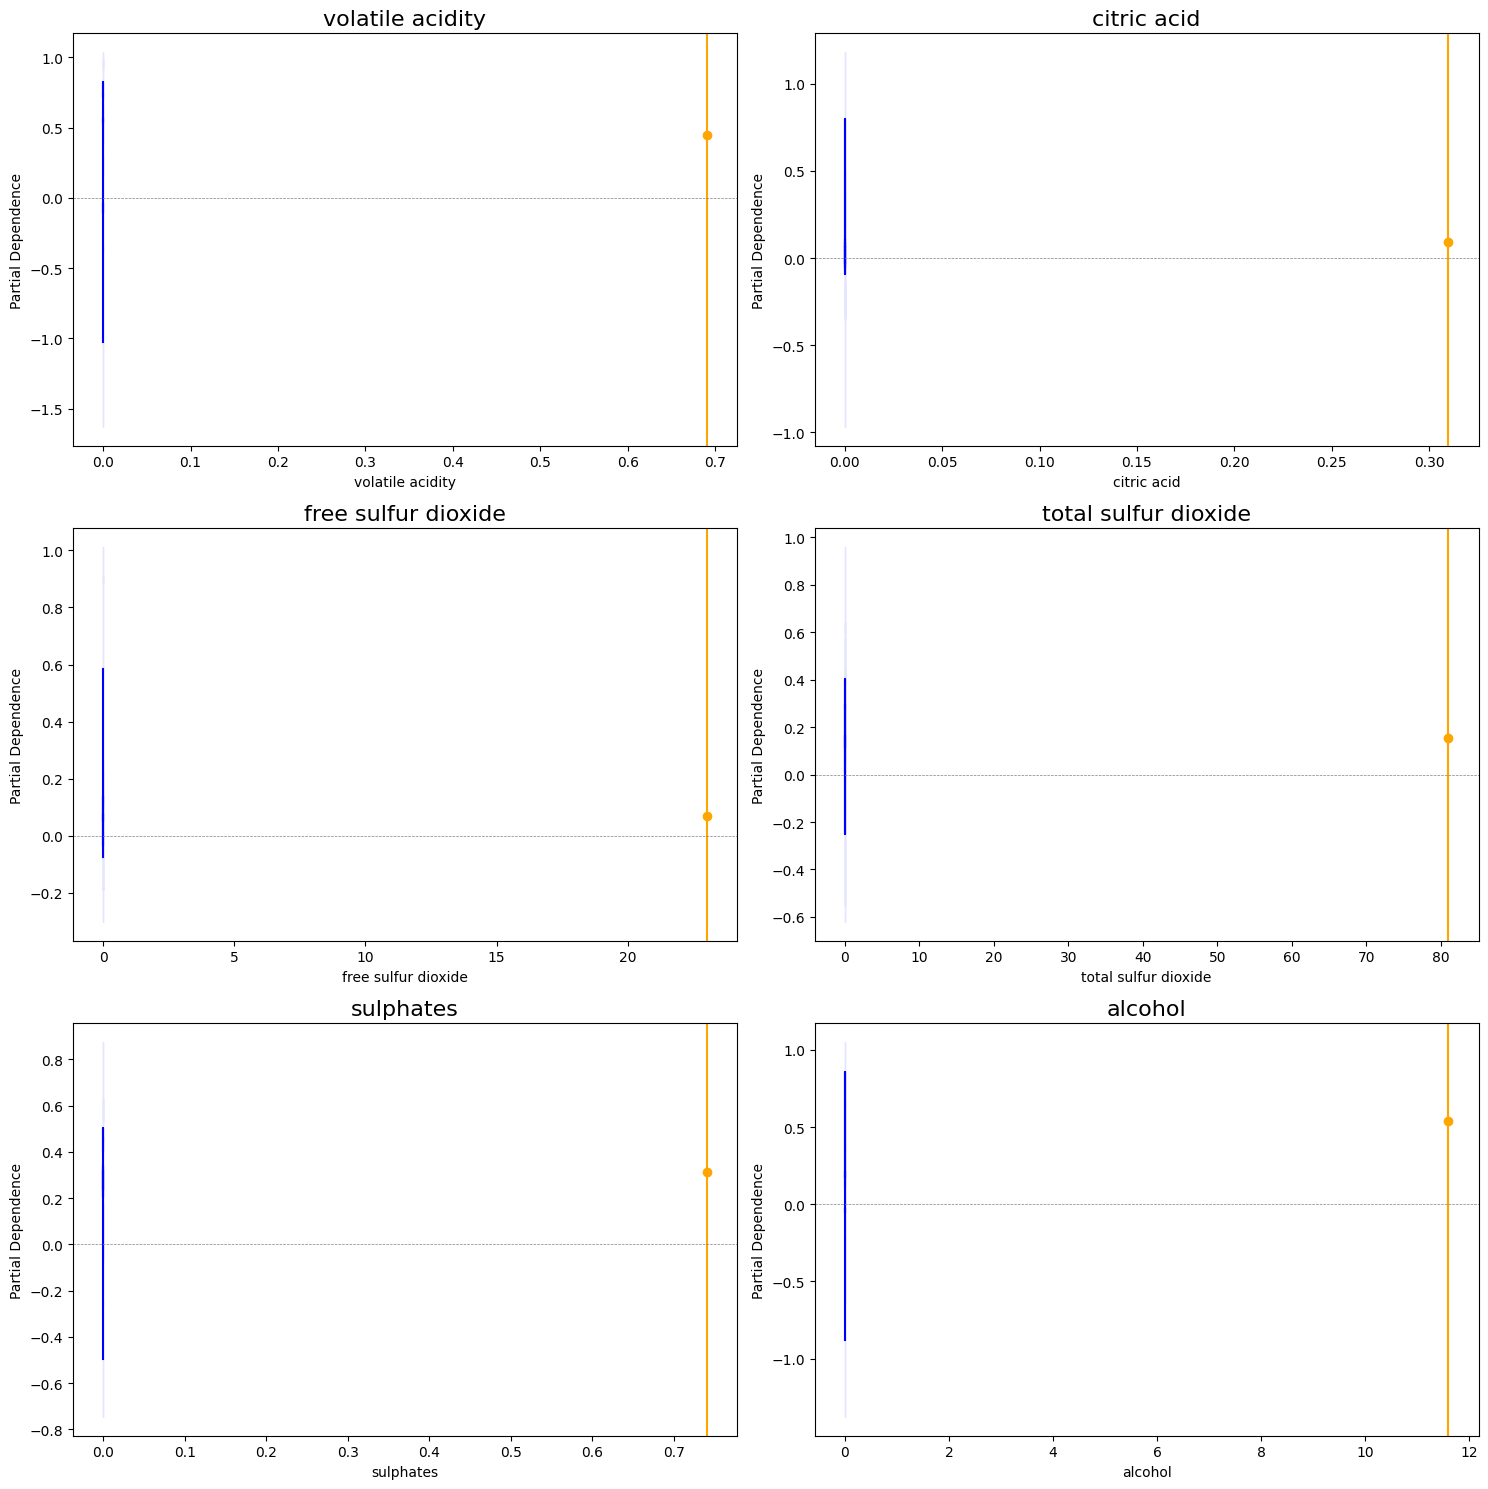

In [64]:
import matplotlib.pyplot as plt

def plot_gam_contributions(gam, instance, contributions, selected_features, selected_feature_indices):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()
    
    for idx, (feature, feature_idx) in enumerate(zip(selected_features, selected_feature_indices)):
        ax = axes[idx]
        XX = gam.generate_X_grid(term=feature_idx)
        pdep, confi = gam.partial_dependence(term=feature_idx, width=0.9)
        
        # 绘制形状函数和置信区间
        ax.plot(XX[:, 0], pdep, color='blue')
        ax.fill_between(XX[:, 0], confi[:, 0], confi[:, 1], alpha=0.1, color='blue')
        
        # 高亮实例的特定值在形状函数图上的位置
        color = 'orange' if contributions[idx][0] >= 0 else 'green'
        ax.axvline(instance[feature_idx], color=color, linestyle='-')
        ax.scatter(instance[feature_idx], contributions[idx][0], color=color)
        
        # 添加0的水平分界线
        ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
        
        ax.set_title(f'{feature}', fontsize=16)
        ax.set_xlabel(feature)
        ax.set_ylabel('Partial Dependence')
    
    plt.tight_layout()
    plt.show()

# 绘制特定特征的贡献
plot_gam_contributions(gam, instance, contributions, selected_features, selected_feature_indices)


In [8]:
xxs[1].shape

(100, 11)